# Traffic Sign Recognition using CNN

This is my implementation of the Tutorial [Traffic Sign Recognision using CNN](https://data-flair.training/blogs/python-project-traffic-signs-recognition/). It is one of the projects in [DataFlair’s series of machine learning projects](https://data-flair.training/blogs/python-machine-learning-project-detecting-parkinson-disease/).
In this notebook, we will develop and train the ML model using PyTorch which we can later package into a standalone applications.

## Dataset

For training the model we will use the [Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). It was made available in 2011 as part of a competition at the International Joint Conference on Neural Networks (IJCNN). The dataset contains  43 classes and over 50,000 images in total.  It is about 300 MB in size and the Training set can be downloaded from this [link](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip) and the test set can be downloaded from this [link](http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip).

Once you download the dataset, it contains 3 folders: Train, Test and Meta.

<img src="images/dataset folders.png" width="200px" />

Inside the *Train* folder there are 43 folders labeled from 0 to 42 and each folder contains images for a specific class.

## Loading the training data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image

In [2]:
X = [] #images stored as np array
y = [] #class labels (0 to 42)

classes = 43
current_path = os.getcwd()

for i in range(classes):
    path = os.path.join(current_path, 'data', 'train', str(i))
    images = os.listdir(path)
    
    for img_name in images:
        image = Image.open(path + '\\' + img_name)
        image = image.resize((30, 30))
        image = np.array(image)
        X.append(image)
        y.append(i)
        
X = np.array(X)
y = np.array(y)

Each image is resized to be of size 30x30 because that is what out neural network is expecting the input to be. Because each image is colored it has three channels (R,G,B), we expected our traning data to have the shape (N, 30, 30, 3) where N = total number of training instance [=39,209].

In [3]:
# shape of training data
X.shape

(39209, 30, 30, 3)

## Train/Test Split

At this point, it is a good idea to split the data into training data and testing data where the former is used in training the model while the later is used to evaluate its performance on unseen data before deploying it into a production environment.

In [4]:
def train_test_split(data, labels, test_size=0.2, random_state=0):
    np.random.seed(random_state)
    N = labels.shape[0]
    idx = np.random.permutation(N)
    train_size = int(np.ceil((1-test_size)*N))
    X_train = data[idx[:train_size]]
    y_train = labels[idx[:train_size]]
    X_test = data[idx[train_size:]]
    y_test = labels[idx[train_size:]]
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (31368, 30, 30, 3)
X_test shape: (7841, 30, 30, 3)
y_train shape: (31368,)
y_test shape: (7841,)


## Building the Model

to classify the images we will build a CNN model that has the following architecture:

`CONV2D -> CONV2D -> MAXPOOL -> DROPOUT -> CONV2D -> CONV2D -> MAXPOOL -> DROPOUT --> FLATTEN -> FULLYCONNECTED -> DROPOUT -> FULLYCONNECTED`

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [17]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5) #output (26,26,32)
        self.conv2 = nn.Conv2d(32, 32, 5) #output (22,22,32)
        self.pool1 = nn.MaxPool2d(2,2) #output (11,11,32)
        self.dropout1 = nn.Dropout(0.25) #output (11,11,32)
        self.conv3 = nn.Conv2d(32, 64, 3) #output(9,9,64)
        self.conv4 = nn.Conv2d(64, 64, 3) #output (7,7,64)
        self.pool2 = nn.MaxPool2d(2,2)  #output (3,3,64)
        self.dropout2 = nn.Dropout(0.25) #output (3,3,64)
        self.fc1 = nn.Linear(3*3*64,256) #output (256, 1)
        self.dropout3 = nn.Dropout(0.5) #output (256, 1)
        self.fc2 = nn.Linear(256, 43) #output (43, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [18]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=43, bias=True)
)

we will use the cross entroy loss and the adam optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Train the model

we will train the model using batch size of 64 and for 15 epochs

In [20]:
# data loaded as (batch, width, height, channels) 
# but pytorch expects (batch,channels, width, height) 
X_train_tensor = torch.from_numpy(np.transpose(X_train, (0, 3, 1, 2))).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_val_tensor = torch.from_numpy(np.transpose(X_test, (0, 3, 1, 2))).float()
y_val_tensor = torch.from_numpy(y_test).long()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(dataset=train_data, batch_size=64)
val_dataloader = DataLoader(dataset=val_data, batch_size=64)
dataloaders = {'train': train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train': len(X_train), 'val': len(X_test)}

In [21]:
def train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15):
    
    since = time.time()
    epoch_loss = []
    epoch_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            i = 0
            running_loss = 0.0
            running_corrects = 0
            
            if phase == 'train':
                 print(f'\rProgress:',end='')
                       
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and i % 50 == 49:
                    print(f"\rProgress: [{'='*((i+1)//50)}] ",end='')
                i += 1
                                  
            epoch_loss.append(running_loss / dataset_sizes[phase])
            epoch_acc.append(running_corrects.numpy() / dataset_sizes[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss[-1], epoch_acc[-1]))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return epoch_loss, epoch_acc

In [22]:
epoch_loss, epoch_acc = train_model(model, criterion, optimizer, dataset_sizes, num_epochs=15)

Epoch 0/14
----------
Progress: [=========] train Loss: 0.0280 Acc: 0.4966
val Loss: 0.0086 Acc: 0.8652

Epoch 1/14
----------
Progress: [=========] train Loss: 0.0100 Acc: 0.8148
val Loss: 0.0043 Acc: 0.9410

Epoch 2/14
----------
Progress: [=========] train Loss: 0.0066 Acc: 0.8723
val Loss: 0.0024 Acc: 0.9570

Epoch 3/14
----------
Progress: [=========] train Loss: 0.0054 Acc: 0.8982
val Loss: 0.0018 Acc: 0.9689

Epoch 4/14
----------
Progress: [=========] train Loss: 0.0050 Acc: 0.9072
val Loss: 0.0024 Acc: 0.9557

Epoch 5/14
----------
Progress: [=========] train Loss: 0.0049 Acc: 0.9071
val Loss: 0.0019 Acc: 0.9670

Epoch 6/14
----------
Progress: [=========] train Loss: 0.0044 Acc: 0.9183
val Loss: 0.0014 Acc: 0.9764

Epoch 7/14
----------
Progress: [=========] train Loss: 0.0040 Acc: 0.9237
val Loss: 0.0016 Acc: 0.9719

Epoch 8/14
----------
Progress: [=========] train Loss: 0.0040 Acc: 0.9242
val Loss: 0.0018 Acc: 0.9674

Epoch 9/14
----------
Progress: [=========] train Loss:

our model got 93% accuracy on the training dataset. we can plot a graph of the loss and accuracy as they progress over the epochs. 

In [23]:
# plot loss
accuracy = epoch_acc[::2]
val_accuracy = epoch_acc[1::2]
loss = epoch_loss[::2]
val_loss = epoch_loss[1::2]

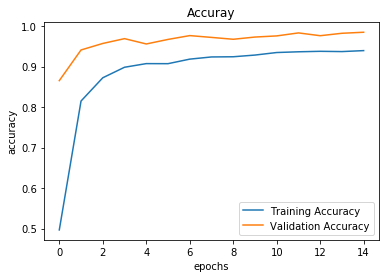

In [24]:
#plot accuracy
plt.figure()
plt.plot(accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuray')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

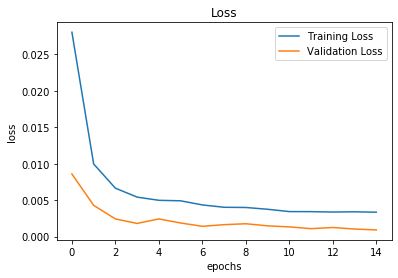

In [25]:
#plot loss
plt.figure()
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [26]:
#save the model to disk
torch.save(model.state_dict(), 'model.pt')

## Testing the model

The dataset contains a test folder and a `test.csv` that contains the correct labels. We will use these data to calculate the accuray of the model.

In [ ]:
py_model = Net()
py_model.load_state_dict(torch.load('model.pt'))

In [73]:
#load the csv file
N = 5000
import pandas as pd
current_path = os.getcwd()
test_model_data = pd.read_csv(open(os.path.join(current_path, 'data', 'test.csv'), "rb"))

y_test_labels = test_model_data['ClassId'][:N]
img_paths = test_model_data['Path'][:N]
x_test_labels = []

#read images from disk
for img in img_paths:
    image = Image.open(os.path.join(current_path, 'data',img))
    image = image.resize((30,30))
    x_test_labels.append(np.array(image))
    
x_test_labels = np.array(x_test_labels)

In [74]:
#convert images to tensors
X_test_labels_tensor = torch.from_numpy(np.transpose(x_test_labels, (0, 3, 1, 2))).float()
y_test_labels_tensor = torch.from_numpy(y_test_labels.values).long()

In [75]:
#predict the outputs
model.eval()
y_test_outputs = model(X_test_labels_tensor)
_, y_test_preds = torch.max(y_test_outputs, 1)
acc = torch.sum(y_test_preds == y_test_labels_tensor.data).float()/len(y_test_labels)
print(f"{acc:.2%}")

95.68%
